##  Exploring the Relationship Between Optimal "K"-Nearest Neighbors and Sample Density in a Geospatial Context

#### Xihan Yao
#### Department of Geography and the Environment, College of Liberal Arts

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences

_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Maria Gonzalez, Graduate Student, The University of Texas at Austin


## Executive Summary

This project examines a question in geospatial machine learning: how sample density influences the optimal K in K-Nearest Neighbors, beyond simply relying on brute-force hyperparameter tuning. 

We conducted two experiments using temperature data from Austin, Texas, varying sample densities and comparing models using (1) only spatial coordinates (x and y, each weakly correlated with temperature) versus (2) coordinates (x and y) plus NDVI (a vegetation index strongly correlated with temperature). 

Results show that optimal K (1) **decreases** as sample density increases when using **only x–y coordinates**, but (2) **increases** with higher sample density **when NDVI is included**, while MSE always decreases when sample density increases. 

These findings indicate that optimal K patterns are shaped not only by sample density but also by feature selection, geographic patterns, and feature linearity, and future studies should account for these characteristics when interpreting or choosing the optimal K.

### Import Packages


In [32]:
%matplotlib inline

seed = 13
suppress_warnings = True

import numpy as np
import pandas as pd
import math
import datetime

# Scikit-learn (KNN + model evaluation)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import metrics

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, FuncFormatter
from matplotlib.colors import ListedColormap
plt.rc("axes", axisbelow=True)
cmap = plt.cm.inferno
import seaborn as sns

if suppress_warnings:
    import warnings
    warnings.filterwarnings("ignore")

### Functions

The following code block is adapted from Professor Michael Pyrcz (@GeostatsGuy), specifically from the notebook *MachineLearning_knearest_neighbours.ipynb* in the [GeostatsGuy GitHub repository](https://github.com/GeostatsGuy/MachineLearningDemos_Book/blob/main/MachineLearning_knearest_neighbours.html).


In [2]:
def comma_format(x, pos):
    return f'{int(x):,}'

def feature_rank_plot(pred,metric,mmin,mmax,nominal,title,ylabel,mask): # feature ranking plot
    mpred = len(pred); mask_low = nominal-mask*(nominal-mmin); mask_high = nominal+mask*(mmax-nominal); m = len(pred) + 1
    plt.plot(pred,metric,color='black',zorder=20)
    plt.scatter(pred,metric,marker='o',s=10,color='black',zorder=100)
    plt.plot([-0.5,m-1.5],[0.0,0.0],'r--',linewidth = 1.0,zorder=1)
    plt.fill_between(np.arange(0,mpred,1),np.zeros(mpred),metric,where=(metric < nominal),interpolate=True,color='dodgerblue',alpha=0.3)
    plt.fill_between(np.arange(0,mpred,1),np.zeros(mpred),metric,where=(metric > nominal),interpolate=True,color='lightcoral',alpha=0.3)
    plt.fill_between(np.arange(0,mpred,1),np.full(mpred,mask_low),metric,where=(metric < mask_low),interpolate=True,color='blue',alpha=0.8,zorder=10)
    plt.fill_between(np.arange(0,mpred,1),np.full(mpred,mask_high),metric,where=(metric > mask_high),interpolate=True,color='red',alpha=0.8,zorder=10)  
    plt.xlabel('Predictor Features'); plt.ylabel(ylabel); plt.title(title)
    plt.ylim(mmin,mmax); plt.xlim([-0.5,m-1.5]); add_grid();
    return

def plot_corr(corr_matrix,title,limits,mask):                 # plots a graphical correlation matrix 
    my_colormap = plt.get_cmap('RdBu_r', 256)          
    newcolors = my_colormap(np.linspace(0, 1, 256))
    white = np.array([256/256, 256/256, 256/256, 1])
    white_low = int(128 - mask*128); white_high = int(128+mask*128)
    newcolors[white_low:white_high, :] = white                # mask all correlations less than abs(0.8)
    newcmp = ListedColormap(newcolors)
    m = corr_matrix.shape[0]
    im = plt.matshow(corr_matrix,fignum=0,vmin = -1.0*limits, vmax = limits,cmap = newcmp)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns); ax = plt.gca()
    ax.xaxis.set_label_position('bottom'); ax.xaxis.tick_bottom()
    plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.ax.yaxis.set_major_formatter(FuncFormatter(comma_format))
    plt.title(title)
    for i in range(0,m):
        plt.plot([i-0.5,i-0.5],[-0.5,m-0.5],color='black')
        plt.plot([-0.5,m-0.5],[i-0.5,i-0.5],color='black')
    plt.ylim([-0.5,m-0.5]); plt.xlim([-0.5,m-0.5])
    
def visualize_model(model,xfeature,x_min,x_max,yfeature,y_min,y_max,response,z_min,z_max,title,axes_commas = True): # plots the data points and the decision tree prediction 
    n_classes = 10
    cmap_temp = plt.cm.inferno
    xplot_step = (x_max-x_min)/100; yplot_step = (y_max-y_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, xplot_step),
                     np.arange(y_min, y_max, yplot_step))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap_temp,vmin=z_min, vmax=z_max, levels=np.linspace(z_min, z_max, 100))

    im = plt.scatter(xfeature,yfeature,s=30, c=response, marker=None, cmap=cmap_temp, norm=None, vmin=z_min, vmax=z_max, 
                     alpha=1.0, linewidths=0.8, edgecolors="black",zorder=10)
    plt.scatter(xfeature,yfeature,s=60, c='white', marker=None, cmap=cmap_temp, norm=None, vmin=z_min, vmax=z_max, 
                     alpha=1.0, linewidths=0.8, edgecolors=None,zorder=8)
    plt.title(title); plt.xlabel(xfeature.name); plt.ylabel(yfeature.name)
    cbar = plt.colorbar(im, orientation = 'vertical'); cbar.set_label(response.name, rotation=270, labelpad=20)
    cbar.ax.yaxis.set_major_formatter(FuncFormatter(comma_format))
    if axes_commas == True:
        plt.gca().xaxis.set_major_formatter(FuncFormatter(comma_format))
        plt.gca().yaxis.set_major_formatter(FuncFormatter(comma_format))
    return Z
    
def visualize_tuned_model(k_tuned,k_mat,score_mat):
    plt.scatter(k_mat,score_mat,s=10.0, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, 
                linewidths=0.5, edgecolors="black")
    plt.plot([k_tuned,k_tuned],[0,10000000],color='black',linestyle=(6, (2,3)),label='tuned',zorder=1)
    plt.title('k-fold Cross Validation Error (MSE) vs. k Nearest Neighbours'); plt.xlabel('Number of Nearest Neighbours')
    plt.ylabel('Mean Square Error')
    plt.xlim(k_min,k_max); plt.ylim(0,np.max(score_mat))
    
def check_model(model,xtrain,ytrain,xtest,ytest,ymin,ymax,rtrain,rtest,title): # plots the estimated vs. the actual  
    predict_train = model.predict(np.c_[xtrain,ytrain])
    predict_test = model.predict(np.c_[xtest,ytest])
    plt.scatter(rtrain,predict_train,s=None, c='darkorange',marker=None, cmap=None, norm=None, vmin=None, vmax=None, 
                alpha=0.8, linewidths=0.8, edgecolors="black",label='Train')
    plt.scatter(rtest,predict_test,s=None, c='red',marker=None, cmap=None, norm=None, vmin=None, vmax=None, 
                alpha=0.8, linewidths=0.8, edgecolors="black",label='Test')
    plt.title(title); plt.xlabel('Actual Production (MCFPD)'); plt.ylabel('Estimated Production (MCFPD)')
    plt.xlim(ymin,ymax); plt.ylim(ymin,ymax)
    plt.arrow(ymin,ymin,ymax,ymax,width=0.02,color='black',head_length=0.0,head_width=0.0)
    MSE_train = metrics.mean_squared_error(rtrain,predict_train)
    Var_Explained_train = metrics.explained_variance_score(rtrain,predict_train)
    cor_train = math.sqrt(metrics.r2_score(rtrain,predict_train))
    MSE_test = metrics.mean_squared_error(rtest,predict_test)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(comma_format))
    plt.gca().yaxis.set_major_formatter(FuncFormatter(comma_format))
    plt.annotate('Train MSE: ' + str(f'{(np.round(MSE_train,2)):,}'),[0.05*(ymax-ymin)+ymin,0.95*(ymax-ymin)+ymin]) 
    plt.annotate('Test MSE:  ' + str(f'{(np.round(MSE_test,2)):,}'),[0.05*(ymax-ymin)+ymin,0.90*(ymax-ymin)+ymin])
    add_grid(); plt.legend(loc='lower right')
    # print('Mean Squared Error on Training = ', round(MSE_test,2),', Variance Explained =', round(Var_Explained,2),'Cor =', round(cor,2))

# def weighted_percentile(data, weights, perc):                 # calculate weighted percentile (iambr on StackOverflow @ https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy/32216049) 
#     ix = np.argsort(data)
#     data = data[ix] 
#     weights = weights[ix] 
#     cdf = (np.cumsum(weights) - 0.5 * weights) / np.sum(weights) 
#     return np.interp(perc, cdf, data)

# def histogram_bounds(values,weights,color):                   # add uncertainty bounds to a histogram          
#     p10 = weighted_percentile(values,weights,0.1); avg = np.average(values,weights=weights); p90 = weighted_percentile(values,weights,0.9)
#     plt.plot([p10,p10],[0.0,45],color = color,linestyle='dashed')
#     plt.plot([avg,avg],[0.0,45],color = color)
#     plt.plot([p90,p90],[0.0,45],color = color,linestyle='dashed')

def add_grid():
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks 

# def display_sidebyside(*args):                                # display DataFrames side-by-side (ChatGPT 4.0 generated Spet, 2024)
#     html_str = ''
#     for df in args:
#         html_str += df.head().to_html()  # Using .head() for the first few rows
#     display(HTML(f'<div style="display: flex;">{html_str}</div>'))

## Introduction & Study Background 

This workflow uses the dataset **`LST_samples_with_bands_and_indices.csv`**, a synthetic sample collection generated from Landsat imagery near **Austin, Texas**. All imagery was acquired by **Landsat 8** during Summer 2025. Landsat data are publicly available and can be accessed through platforms such as USGS EarthExplorer, Google Earth Engine, and NASA LP DAAC.

The dataset in this study is hosted on: https://raw.githubusercontent.com/xyaoaf/PGE_383_TermProject_XihanYao/main/LST_samples_with_bands_and_indices.csv


---

This dataset is **synthetic**, created from sampling and extracting different band values from a Landsat 8 image. The Area of Interests (AOI) a bounding box covering Austin, TX and and its surrounding areas: AOI = [-98.05, 30.10, -97.50, 30.55] 

A total of **3,924 samples** were collected:

- The first 2,000 samples were drawn *completely at random*.
- The remaining 1,924 samples were intentionally drawn near temperature “hotspots”, identified from the warmest pixels in the first 2,000 samples.

This design mimics a realistic scenario: due to the Urban Heat Island (UHI) effect, urbanized areas are typically warmer than surrounding rural zones. In Austin, the city center shows noticeably higher temperatures. I assume that more people reside in these warmer, urbanized areas, leading to higher levels of citizen science participation, and therefore higher sampling density.

As a result, the final sample distribution is **not spatially random**. Additionally, no samples were taken over water bodies.

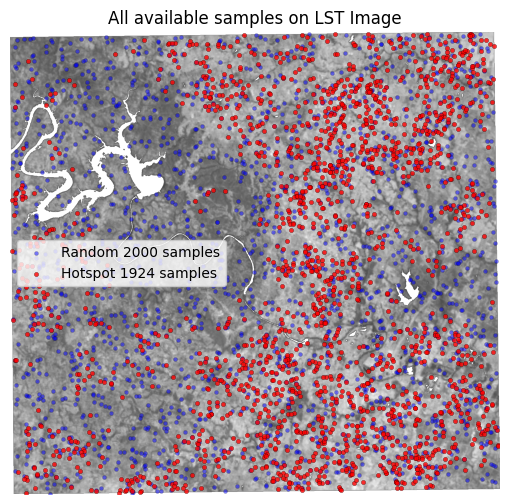

After selecting the sample locations, reflectance values from **Landsat Bands 2–9** were extracted at each point. Several vegetation indices were then calculated.

From this point forward, our analysis uses **only the resulting tabular dataset**.  
The original images were used solely to generate the samples; they are *not* used directly in the remainder of the workflow.


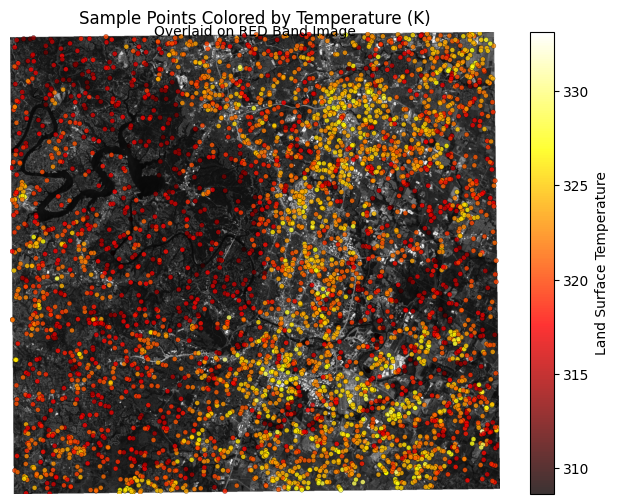


**Target Variable**
- **Temperature (Land Surface Temperature, LST)**  
  A measure of the Earth’s surface temperature derived from thermal infrared radiation, or measured by thermal meters
  *Note: LST is not equivalent to air temperature, but here I use it to represent the thermal condition.*

**Predictor Variables**
- **X_coor** – X coordinate of the sample location (column index).  
- **Y_coor** – Y coordinate of the sample location (row index).  
- **NDVI** – *Normalized Difference Vegetation Index*  
$NDVI = \frac{B5 - B4}{B5 + B4}$, Indicates vegetation greenness using Near-Infrared (B5) and Red (B4) reflectance.

**Other Landsat Surface Reflectance Bands and Normalized Indices**

They are briefly explored but not used in any KNN models. Future users are welcome to try them. 
- **B2 – Blue**
- **B3 – Green**
- **B4 – Red**
- **B5 – Near Infrared (NIR)**
- **B6 – SWIR1** (shortwave infrared)
- **B7 – SWIR2** (useful for dryness/burned areas)
- **B8 – Panchromatic**
- **B9 – Cirrus** (used to detect high-altitude thin clouds)
- **EVI – Enhanced Vegetation Index**  
$EVI = 2.5 \cdot \frac{B5 - B4}{B5 + 6B4 - 7.5B2 + 1}$, Less sensitive to atmospheric and canopy effects than NDVI.

- **NDWI – Normalized Difference Water Index**  
$NDWI = \frac{B3 - B5}{B3 + B5}$, Highlights open water and vegetation moisture.

## Workflow Summary

This workflow consists of five major steps, with Steps 3 and 4 forming the core of the analysis:

**Step 0 — Data Preparation and Exploration**  
Including correlation checks.

**Step 1 — (SKIP IF ALREADY FAMILIAR) The Common Practice: Build One KNN Model and Tune for Optimal *K***  
We begin by constructing a single KNN model and performing hyperparameter tuning to establish a baseline optimal *K*. This step can be skipped if already familiar with the procedure.

**Step 2 — Distribution of Optimal *K* for a Fixed Sample Size**  
We investigate the stability of the optimal *K* by repeatedly drawing 1,000-point subsets and tuning a KNN model each time (1,000 iterations). This reveals the distribution and variability of optimal *K* under a fixed sample size.

**Step 3 — Relationship Between Optimal *K* and Sample Size: X–Y Only Model**  
We explore how the optimal *K* changes as sample size varies, using a model with only spatial coordinates (x and y) as predictors.

**Step 4 — Relationship Between Optimal *K* and Sample Size: X–Y + NDVI Model**  
We repeat the sample-size experiment using both spatial coordinates and NDVI as predictors, allowing us to compare how feature selection influences the relationship between sample size and optimal *K*.



## Step 0: Data Preperation and Exploration

Load Data

We begin by loading the dataset and inspecting the last five rows.  
`x_coor` and `y_coor` represent the **relative geographic coordinates** of each sample within the study area, where coordinates start at 0 and increase by 1 for each pixel.

In [3]:
url = "https://raw.githubusercontent.com/xyaoaf/PGE_383_TermProject_XihanYao/main/LST_samples_with_bands_and_indices.csv"
df = pd.read_csv(url).rename(columns={'land surface temperature':'Temperature'})
df.tail()

x_coor  y_coor         x          y  Temperature   B2_blue  B3_green  \
3919    1161     402  625935.0  3368625.0   324.522156  0.343863  0.305664   
3920    1151     417  625635.0  3368175.0   325.062225  0.349245  0.356557   
3921     602    1641  609165.0  3331455.0   324.710144  0.263605  0.247576   
3922     630    1659  610005.0  3330915.0   323.623230  0.266998  0.252666   
3923     595    1651  608955.0  3331155.0   323.872742  0.246640  0.218562   

        B4_red    B5_NIR  B6_SWIR1  B7_SWIR2    B8_pan  B9_cirrus      NDVI  \
3919  0.294550  0.533043  0.342576  0.223788  0.160471   0.001534  0.288177   
3920  0.381535  0.713332  0.453448  0.299522  0.125149   0.001045  0.303047   
3921  0.251028  0.773174  0.473961  0.245471  0.094784   0.001045  0.509808   
3922  0.250384  0.851034  0.490691  0.230690  0.093917   0.001334  0.545342   
3923  0.189138  0.730705  0.407976  0.196255  0.098141   0.001289  0.588761   

           EVI      NDWI  
3919  0.826530 -0.271106  
3920  0.599687 -0.333469  
3921  1.002350 -0.514913  
3922  1.111608 -0.542148  
3923  1.332955 -0.539515

Describe data

In [4]:
df.describe().transpose()

count          mean           std           min           25%  \
x_coor       3924.0  1.003373e+03    484.266950  5.000000e+00  6.477500e+02   
y_coor       3924.0  8.702317e+02    505.047647  5.000000e+00  4.130000e+02   
x            3924.0  6.212062e+05  14528.008510  5.912550e+05  6.105375e+05   
y            3924.0  3.354578e+06  15151.429411  3.330285e+06  3.340808e+06   
Temperature  3924.0  3.210052e+02      3.584383  3.086420e+02  3.184817e+02   
B2_blue      3924.0  2.846186e-01      0.089499  1.914191e-01  2.327620e-01   
B3_green     3924.0  2.655210e-01      0.109439  1.277155e-01  2.008079e-01   
B4_red       3924.0  2.552204e-01      0.140695  6.664436e-02  1.666601e-01   
B5_NIR       3924.0  6.926395e-01      0.123157  8.325759e-02  6.111517e-01   
B6_SWIR1     3924.0  3.731349e-01      0.128798  0.000000e+00  2.795550e-01   
B7_SWIR2     3924.0  2.035617e-01      0.103168  0.000000e+00  1.320931e-01   
B8_pan       3924.0  1.176277e-01      0.047012  5.859555e-02  8.905479e-02   
B9_cirrus    3924.0  1.196659e-03      0.000192  5.557241e-04  1.066990e-03   
NDVI         3924.0  4.842432e-01      0.159843  0.000000e+00  3.898600e-01   
EVI          3924.0  1.096127e+00      0.445610 -2.672809e+00  8.054511e-01   
NDWI         3924.0 -4.555259e-01      0.118347 -7.128752e-01 -5.367087e-01   

                      50%           75%           max  
x_coor       1.083000e+03  1.395000e+03  1.777000e+03  
y_coor       8.925000e+02  1.329250e+03  1.680000e+03  
x            6.235950e+05  6.329550e+05  6.444150e+05  
y            3.353910e+06  3.368295e+06  3.380535e+06  
Temperature  3.214340e+02  3.237224e+02  3.331321e+02  
B2_blue      2.612648e-01  3.057812e-01  1.000000e+00  
B3_green     2.381584e-01  2.932628e-01  1.000000e+00  
B4_red       2.225396e-01  3.012916e-01  1.000000e+00  
B5_NIR       6.797251e-01  7.675149e-01  1.000000e+00  
B6_SWIR1     3.594037e-01  4.464477e-01  1.000000e+00  
B7_SWIR2     1.872852e-01  2.554053e-01  1.000000e+00  
B8_pan       1.062878e-01  1.301506e-01  5.733295e-01  
B9_cirrus    1.200364e-03  1.311509e-03  2.045065e-03  
NDVI         5.041347e-01  6.002413e-01  8.284588e-01  
EVI          1.091362e+00  1.386528e+00  6.864978e+00  
NDWI        -4.809676e-01 -3.985242e-01  2.107280e-01

First we will do a correlation analysis, to see the relationships among different features. The following code blocks are adapted the notebook *MachineLearning_knearest_neighbours.ipynb* in the [GeostatsGuy GitHub repository](https://github.com/GeostatsGuy/MachineLearningDemos_Book/blob/main/MachineLearning_knearest_neighbours.html).

In [5]:
response = "Temperature"

# Remove response + original x y from predictors
X = df.drop(columns=[response, "x", "y"])
y = df[response]

# Extract predictor list
pred = X.columns.tolist()
resp = [response]

# Rebuild df ordered as (X | y)
df = pd.concat([X, y], axis=1)

# Basic metadata
mpred = len(pred)

print("Predictors:", pred)
print("Response:", response)
display(df.head())

Predictors: ['x_coor', 'y_coor', 'B2_blue', 'B3_green', 'B4_red', 'B5_NIR', 'B6_SWIR1', 'B7_SWIR2', 'B8_pan', 'B9_cirrus', 'NDVI', 'EVI', 'NDWI']
Response: Temperature


x_coor  y_coor   B2_blue  B3_green    B4_red    B5_NIR  B6_SWIR1  B7_SWIR2  \
0     603     264  0.208734  0.162112  0.113091  0.517424  0.205107  0.084564   
1     924     725  0.265945  0.214233  0.190425  0.549656  0.237788  0.134326   
2     467     775  0.218445  0.180773  0.138421  0.593588  0.190990  0.079884   
3     538    1014  0.281388  0.253192  0.241259  0.733513  0.437381  0.244457   
4     539      37  0.225347  0.200311  0.157725  0.738252  0.312352  0.136666   

     B8_pan  B9_cirrus      NDVI       EVI      NDWI  Temperature  
0  0.077290   0.001134  0.641274  1.603315 -0.522875    314.24417  
1  0.083514   0.001223  0.485395  1.287348 -0.439099    320.11633  
2  0.107544   0.001111  0.621806  1.448148 -0.533105    320.67004  
3  0.103609   0.001111  0.504995  1.149422 -0.486793    319.97960  
4  0.095118   0.001267  0.647927  1.459354 -0.573154    317.55966

We examine intercorrelations among all features and then evaluate the correlation of each predictor with temperature. As expected, the **x-coordinate and y-coordinate show almost no correlation** with other predictors or with temperature, since they only encode the geographic position of each sample and do not exhibit a linear relationship with the response. In contrast, several variables show strong correlations. For example:

- **NDVI and EVI are highly correlated**, as both indices quantify vegetation abundance.  
- **NDVI is negatively correlated with temperature**, reflecting the typical cooling effect of areas with higher vegetation density.

To visualize these patterns, we generate a correlation matrix and a feature-ranking plot that summarize how each predictor relates to temperature. For our KNN analysis, we will only use x_coor, y_coor and NDVI


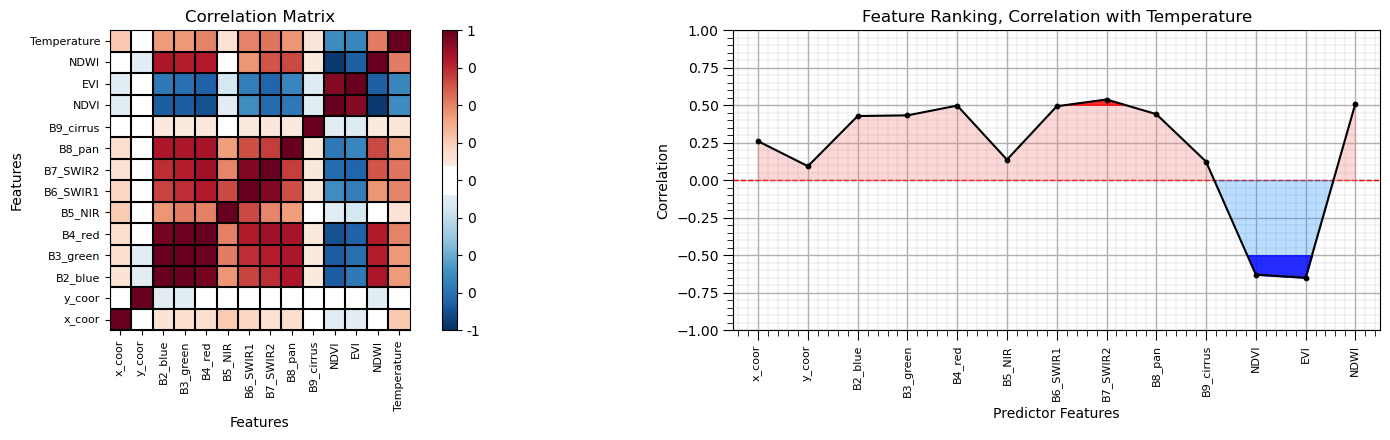

In [6]:
# Subset df to predictors + response
df_corr = df[pred + resp]

# Correlation matrix
corr_matrix = df_corr.corr()

# Correlation of predictors with response
correlation = corr_matrix[response].loc[pred].values

plt.figure(figsize=(16, 5))

# ---- Left plot: correlation matrix ----
plt.subplot(121)
plot_corr(corr_matrix, 'Correlation Matrix', 1.0, 0.1)  # mask value set to 0.1
plt.xlabel('Features')
plt.ylabel('Features')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

# ---- Right plot: predictor ranking by correlation ----
plt.subplot(122)
feature_rank_plot(pred, correlation, -1.0, 1.0, 0.0,
                  'Feature Ranking, Correlation with ' + resp[0],
                  'Correlation', 0.5)
plt.xticks(rotation=90, fontsize=8)
plt.ylabel("Correlation")

# Adjust layout
plt.subplots_adjust(left=0.05, bottom=0.25, right=0.98, top=0.85,
                    wspace=0.3, hspace=0.3)

plt.show()

In a geospatial context, the purpose of this study is to explore the relationship between sample point **density** and the optimal value of *K* in KNN models. However, because the area of the AOI is fixed, sample density and total sample size are linearly related. For this reason, it is clearer and more intuitive to discuss **total sample size**.

Here we estimate the area of our AOI:

In [7]:
# Estimating the AOI area: 
aoi = [-98.05, 30.10, -97.50, 30.55]  
min_lon, min_lat, max_lon, max_lat = aoi
dlat = max_lat - min_lat   # 0.45°
dlon = max_lon - min_lon   # 0.55°

lat_mid = (min_lat + max_lat) / 2
km_per_deg_lat = 111.32
km_per_deg_lon = 111.32 * math.cos(math.radians(lat_mid))

height_km = dlat * km_per_deg_lat
width_km = dlon * km_per_deg_lon

area_km2 = height_km * width_km
print(f"Estimated area_km2 of AOI: {area_km2:.2f} km²")

Estimated area_km2 of AOI: 2647.41 km²


Our original dataset contains 3,924 synthesized pseudo-samples derived from Landsat-based Land Surface Temperature (LST) rasters. In reality, however, it is unreasonable to collect this many ground-truth measurements, since each additional sample would require another field observation or sensing device, making large-scale sampling prohibitively expensive. For this reason, we treat the full set of pseudo-samples as a “population” and draw subsamples of varying sizes to study how model performance changes with sampling effort. 

Based on the size of the study area, we estimated that collecting around 2,700 samples would correspond to a density of roughly **1 point per square kilometer**, which is already extremely high for real-world field campaigns. This motivates the central question of the study: **as we vary the sample size, how does the optimal value of *K* in KNN respond?** 

We vary the sample size in increments of 100, starting with 100 samples and increasing up to 2,700. This allows us to systematically observe how model behavior—and in particular the optimal value of *K*—changes across a wide range of sampling intensities.

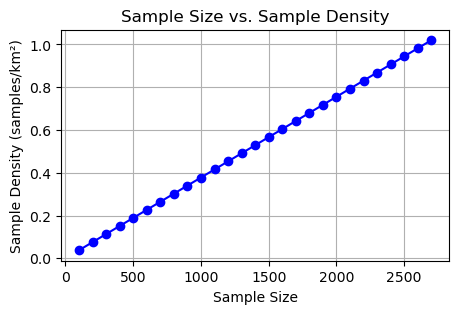

In [8]:
sample_sizes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700]
sample_density = [size / area_km2 for size in sample_sizes]

plt.figure(figsize=(5,3))
plt.plot(sample_sizes, sample_density, marker='o', color='blue')
plt.xlabel('Sample Size')
plt.ylabel('Sample Density (samples/km²)')
plt.title('Sample Size vs. Sample Density')
plt.grid(True)
plt.show()

## Step 1: (SKIP IF ALREADY FAMILIAR) The Common Practice: Build one KNN and Find the Optimal K

This first step is essentially equivalent to the hyperparameter tuning exercise from the lab, where we search for the optimal value of *K* for a single KNN model. You may skim or skip this section if you are already familiar with the process. However, it serves as an important demonstration of how *K* tuning works, and it sets the foundation for the large-scale experiments that follow, in which we will repeat this search thousands of times across many different sample sizes.

For the first model, we perform a full KNN run and identify the optimal value of *K*, using code adapted from the notebook *MachineLearning_knearest_neighbours.ipynb* in the [GeostatsGuy GitHub repository](https://github.com/GeostatsGuy/MachineLearningDemos_Book/blob/main/MachineLearning_knearest_neighbours.html). In this setup, we include only the **X and Y coordinates** as predictors. According to Tobler’s First Law of Geography—“everything is related to everything else, but near things are more related than distant things”—we expect nearby locations to exhibit similar temperatures.

To begin, we standardize the X and Y coordinates, draw a subsample of 1,000 points, and run the KNN model with hyperparameter tuning to determine the optimal *K* for this purely spatial configuration.

In [10]:
# Randomly select 1000 samples from the population
df_sample = df.sample(n=1000, random_state=seed)
coord_features = ['x_coor', 'y_coor']
std_cols = ['sX', 'sY']

# Standardize X and Y for the sampled data
scaler = StandardScaler()
df_sample[std_cols] = scaler.fit_transform(df_sample[coord_features])

# Output
print("Selected Predictor Features:", coord_features)
print("Standardized Feature Names:", std_cols)
print("Response Feature:", response)
print(f"Sampled Data Shape: {df_sample.shape}")
df_sample.tail()

Selected Predictor Features: ['x_coor', 'y_coor']
Standardized Feature Names: ['sX', 'sY']
Response Feature: Temperature
Sampled Data Shape: (1000, 16)


x_coor  y_coor   B2_blue  B3_green    B4_red    B5_NIR  B6_SWIR1  \
3119    1475    1160  0.206921  0.174572  0.124966  0.658988  0.263176   
1424     300     440  0.233947  0.201422  0.166967  0.560420  0.297572   
2933    1653     628  0.312333  0.310286  0.295603  0.760656  0.476613   
3768     443    1579  0.217626  0.178842  0.150705  0.630032  0.327250   
3427     141    1449  0.207272  0.167377  0.116075  0.565275  0.225815   

      B7_SWIR2    B8_pan  B9_cirrus      NDVI       EVI      NDWI  \
3119  0.095601  0.092272   0.001489  0.681190  1.558044 -0.581141   
1424  0.157608  0.081336   0.001400  0.540912  1.217933 -0.471223   
2933  0.291215  0.129017   0.000956  0.440284  0.975547 -0.420537   
3768  0.153240  0.083159   0.001289  0.613942  1.328411 -0.557800   
3427  0.091506  0.070910   0.001312  0.659281  1.587991 -0.543094   

      Temperature        sX        sY  
3119   317.891205  0.963813  0.545581  
1424   319.008900 -1.477378 -0.877380  
2933   325.397186  1.333628 -0.505829  
3768   320.755493 -1.180280  1.373666  
3427   314.818390 -1.807718  1.116742

Train-test split

In [11]:
# Train–test split using the standardized X and Y predictors
X_train, X_test, y_train, y_test = train_test_split(
    df_sample[['sX', 'sY']], df_sample[[response]], 
    test_size=0.25, random_state=73073
)

# Recombine predictors + response
df_train = pd.concat([X_train, y_train], axis=1)
df_test  = pd.concat([X_test, y_test], axis=1)

Let's see the distribution of our training and testing data. They are not normal distributions due to sampling methods

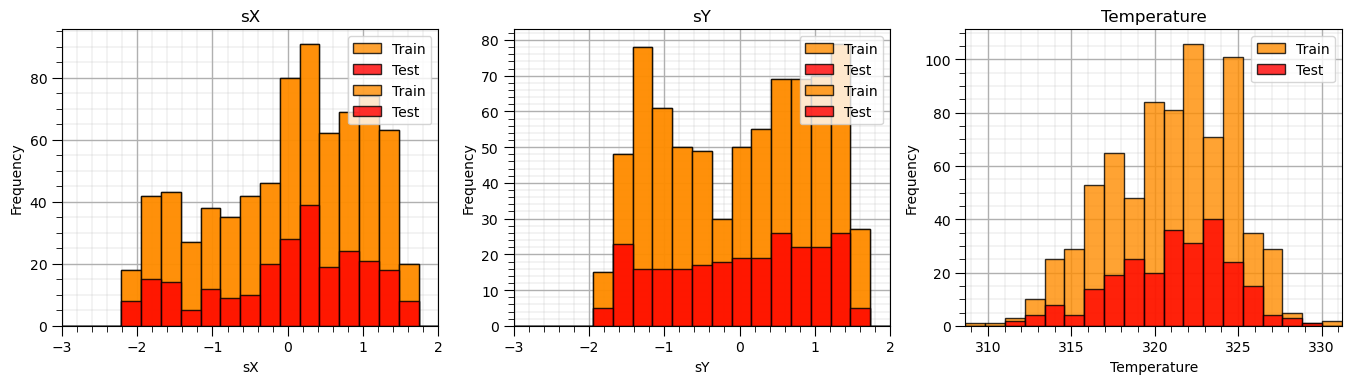

In [20]:
# Compute limits from standardized columns
sxmin, sxmax = df_sample[std_cols[0]].min(), df_sample[std_cols[0]].max()
symin_, symax_ = df_sample[std_cols[1]].min(), df_sample[std_cols[1]].max()
resplabel = response
ymin, ymax = df_sample[response].min(), df_sample[response].max()

# number of histogram bins
nbins = 20

# sX 
plt.subplot(331) 
plt.hist(X_train[std_cols[0]],alpha = 0.8,color = 'darkorange',edgecolor = 'black',bins=np.linspace(-3,2,nbins),label='Train')
plt.hist(X_test[std_cols[0]],alpha = 0.8,color = 'red',edgecolor = 'black',bins=np.linspace(-3,2,nbins),label='Test')
plt.title(std_cols[0]); plt.xlim(-3,2); plt.xlabel(std_cols[0]); plt.ylabel('Frequency'); add_grid(); plt.legend(loc='upper right')

#sY
plt.subplot(332)
plt.hist(X_train[std_cols[1]],alpha = 0.8,color = 'darkorange',edgecolor = 'black',bins=np.linspace(-3,2,nbins),label='Train')
plt.hist(X_test[std_cols[1]],alpha = 0.8,color = 'red',edgecolor = 'black',bins=np.linspace(-3,2,nbins),label='Test')
plt.title(std_cols[1]); plt.xlim(-3,2); plt.xlabel(std_cols[1]); plt.ylabel('Frequency'); add_grid(); plt.legend(loc='upper right')

# Response: Temperature
plt.subplot(333)
plt.hist(y_train[resp],alpha = 0.8,color = 'darkorange',edgecolor = 'black',bins=np.linspace(ymin,ymax,nbins),label='Train')
plt.hist(y_test[resp],alpha = 0.8,color = 'red',edgecolor = 'black',bins=np.linspace(ymin,ymax,nbins),label='Test')
plt.legend(loc='upper right'); plt.title(resp[0]); plt.xlim(ymin,ymax) 
plt.gca().xaxis.set_major_formatter(FuncFormatter(comma_format))
plt.xlabel(resplabel); plt.ylabel('Frequency'); add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.2, hspace=0.2); plt.show()

Since we are working on geospatial data, let's plot them based on x_coor and y_coor. Recall the landscape of Austin, TX and our original large "population" 3924 sample points.

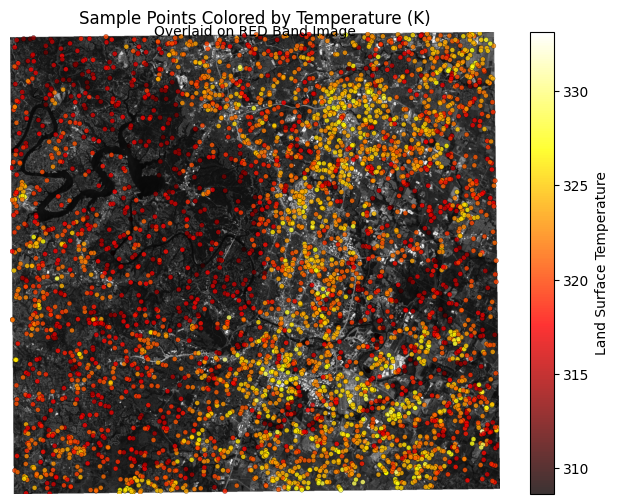

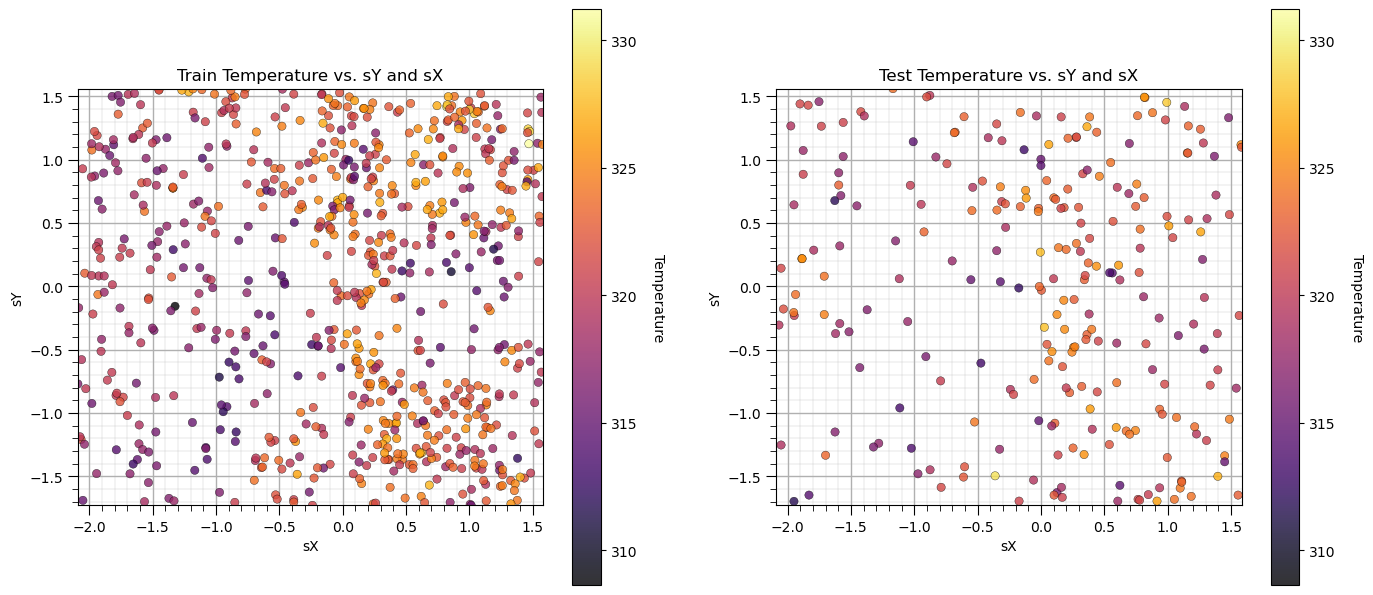

In [21]:
plt.subplot(121)                                              # train data plot
im = plt.scatter(X_train[std_cols[0]],X_train[std_cols[1]],s=None, c=y_train[resp[0]], marker=None, cmap=cmap, norm=None, vmin=ymin, 
                 vmax=ymax, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Train ' + resp[0] + ' vs. ' + std_cols[1] + ' and ' + std_cols[0]); plt.xlabel(std_cols[0]); plt.ylabel(std_cols[1])
plt.xlim(sxmin, sxmax); plt.ylim(symin_, symax_)
plt.gca().set_aspect('equal', adjustable='box')
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label(resplabel, rotation=270, labelpad=20)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(comma_format))
add_grid()

plt.subplot(122)                                               # test data plot
im = plt.scatter(X_test[std_cols[0]],X_test[std_cols[1]],s=None, c=y_test[resp[0]], marker=None, cmap=cmap, norm=None, vmin=ymin, 
                 vmax=ymax, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Test ' + resp[0] + ' vs. ' + std_cols[1] + ' and ' + std_cols[0]); plt.xlabel(std_cols[0]); plt.ylabel(std_cols[1])
plt.xlim(sxmin, sxmax); plt.ylim(symin_, symax_)
plt.gca().set_aspect('equal', adjustable='box')
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label(resplabel, rotation=270, labelpad=20)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(comma_format))
add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2); plt.show()

Here we set up the key KNN hyperparameters for this example. We initialize the model with `n_neighbors = 1`, use `p = 2` to compute Euclidean distance, and set `weights = "uniform"` so that each neighbor contributes equally to the prediction. In other words, the prediction is simply the average of the *K* nearest neighbors, without applying distance-based weighting.

In [22]:
# model hyperparameters
n_neighbours = 10; p = 2; weights = 'uniform'
# instantiate the prediction model
neigh = KNeighborsRegressor(weights = weights,n_neighbors=n_neighbours,p = p) 

Here we visualize the results of the first KNN model that uses only the X and Y coordinates to predict temperature. With just spatial coordinates, the model produces reasonably good predictions. Using 1,000 samples of X and Y, we obtain a training MSE of 7.36 and a test MSE of 9.06. These results suggest that the spatial structure alone carries meaningful predictive power, and the model behaves as expected.

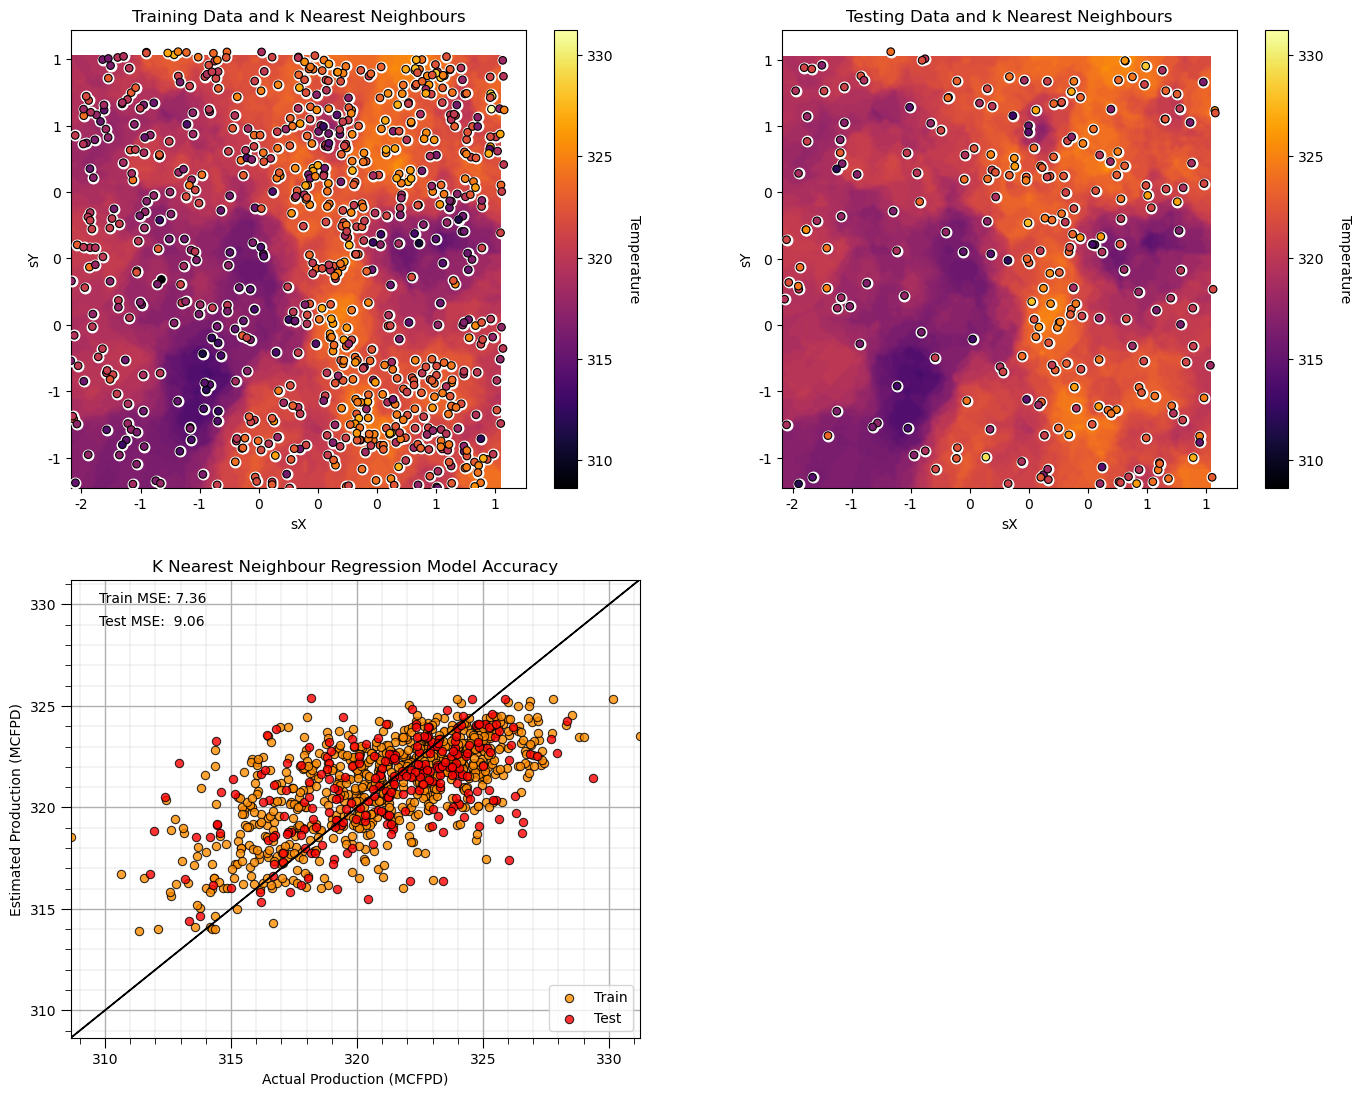

In [23]:
# train the model with the training data
neigh_fit = neigh.fit(X_train,y_train)                        

# training data vs. the model predictions
plt.subplot(221)                                              
Z = visualize_model(neigh_fit,X_train[std_cols[0]],sxmin,sxmax,X_train[std_cols[1]],symin_,symax_,y_train[resp[0]],ymin,ymax,
                    'Training Data and k Nearest Neighbours')
plt.annotate('Hyperparameters',[1.5,3.2],color='white'); plt.annotate('weights: ' + weights,[1.5,2.9],color='white')
plt.annotate('n neighbours: ' + str(n_neighbours),[1.5,2.6],color='white'); plt.annotate('distance norm: ' + str(p),[1.5,2.3],color='white')

# testing data vs. the model predictions
plt.subplot(222)                                              
visualize_model(neigh_fit,X_test[std_cols[0]],sxmin,sxmax,X_test[std_cols[1]],symin_,symax_,y_test[resp[0]],ymin,ymax,
                'Testing Data and k Nearest Neighbours')
plt.annotate('Hyperparameters',[1.5,3.2],color='white'); plt.annotate('weights: ' + weights,[1.5,2.9],color='white')
plt.annotate('n neighbours: ' + str(n_neighbours),[1.5,2.6],color='white'); plt.annotate('distance norm: ' + str(p),[1.5,2.3],color='white')

# model accuracy check
plt.subplot(223)                                              
check_model(neigh_fit,X_train[std_cols[0]],X_train[std_cols[1]],X_test[std_cols[0]],X_test[std_cols[1]],ymin,ymax,
            y_train[resp[0]],y_test[resp[0]],'K Nearest Neighbour Regression Model Accuracy')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.25, hspace=0.2); plt.show()

Since the focus of this study is to examine how the optimal value of *K* changes, we now perform hyperparameter tuning for this model. In this step, we use a simple `while` loop to search over different values of *K*, although later in the workflow we will replace this with a more streamlined function.

In [24]:
# ----- Hyperparameter Tuning Loop -----
k = 1
unif_error = []
k_mat = []

while k <= 100:
    # uniform-weighted KNN
    model = KNeighborsRegressor(weights='uniform', n_neighbors=k, p=2)
    model_fit = model.fit(X_train, y_train)
    y_pred = model_fit.predict(X_test)
    
    # record MSE
    mse = metrics.mean_squared_error(y_test, y_pred)
    unif_error.append(mse)
    
    k_mat.append(k)
    k += 1

# Convert results to arrays (optional)
k_mat = np.array(k_mat)
unif_error = np.array(unif_error)

# ----- Find optimal k -----
k_opt = k_mat[np.argmin(unif_error)]
mse_opt = np.min(unif_error)

print("Optimal K:", k_opt)
print("Minimum MSE:", mse_opt)

Optimal K: 23
Minimum MSE: 8.578342722511076


We plot the relationship between MSE and K. When K is around 10, the MSE reaches its min. 

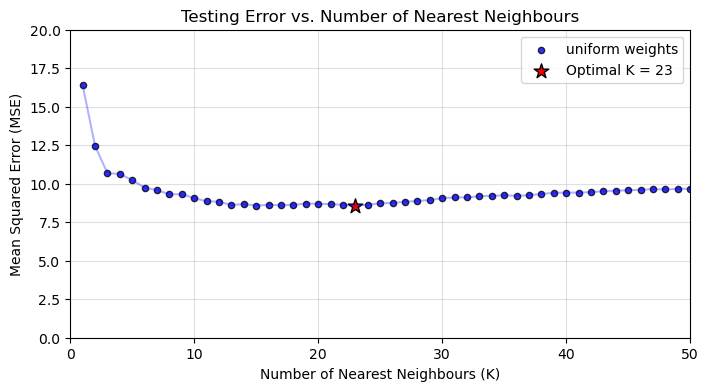

In [25]:
plt.figure(figsize=(8, 4))
plt.scatter(k_mat, unif_error, s=20, c='blue', edgecolors='black', alpha=0.8, label='uniform weights')
plt.plot(k_mat, unif_error, color='blue', alpha=0.3)

# highlight the optimal k
plt.scatter(k_opt, mse_opt, s=120, c='red', marker='*', edgecolors='black', label=f'Optimal K = {k_opt}')

plt.title('Testing Error vs. Number of Nearest Neighbours')
plt.xlabel('Number of Nearest Neighbours (K)')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(alpha=0.4)

plt.xlim(0, 50)
plt.ylim(0, 20)
plt.show()

Alternatively, the whole workflow can be integrated and simplified in to the pipeline as below, using GridSearchCV.

In coming experiments, we will use this pipeline to be more efficient


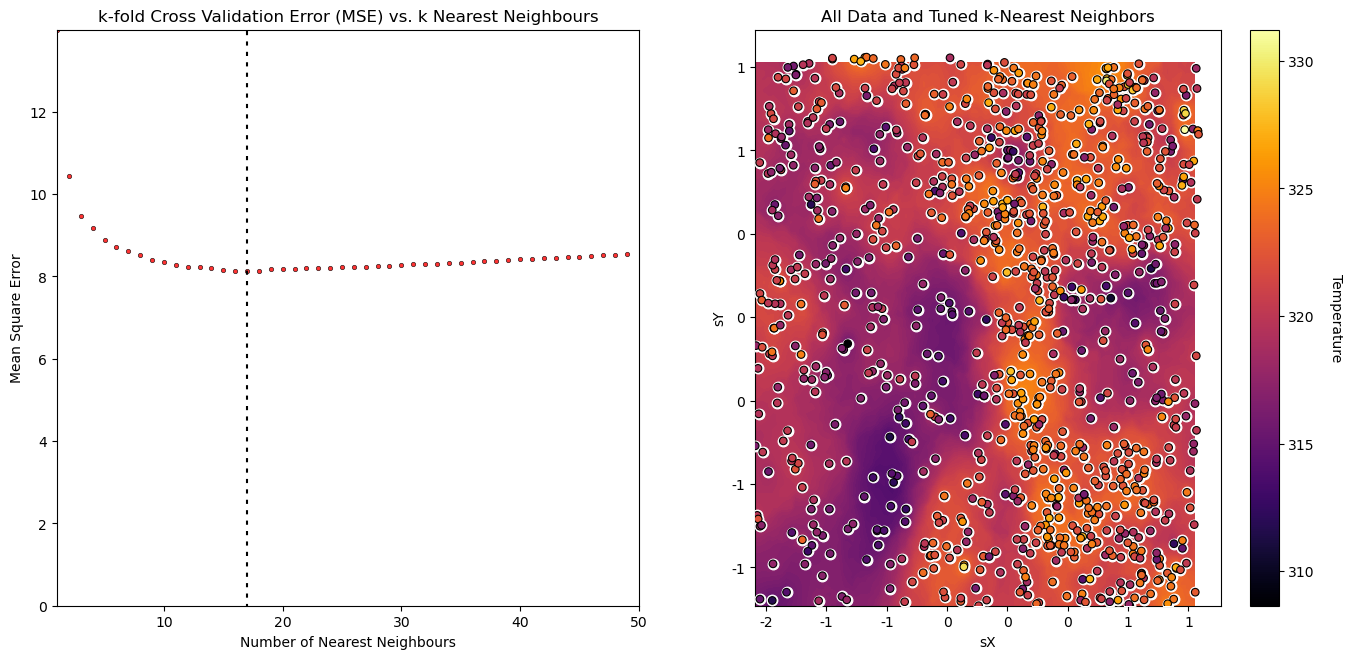

In [26]:
# In a combined workflow
# ------------------------------------------------------------
# Setup
# ------------------------------------------------------------
folds = 4
k_min = 1
k_max = 50

# Predictors: standardized X and Y
X_pipe = df_sample[['sX', 'sY']]
y_pipe = df_sample[response]

# Machine learning pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knear', KNeighborsRegressor())
])

# Hyperparameter search space
params = {
    'scaler': [StandardScaler()],
    'knear__n_neighbors': np.arange(k_min, k_max, 1, dtype=int),
    'knear__metric': ['euclidean'],
    'knear__p': [2],              # p=2 → Euclidean
    'knear__weights': ['distance']
}

# Grid search cross-validation
grid_cv_tuned = GridSearchCV(
    estimator=pipe,
    param_grid=params,
    scoring='neg_mean_squared_error',
    cv=KFold(n_splits=folds, shuffle=False),
    refit=True
)

# Fit the tuned model
grid_cv_tuned.fit(X_pipe, y_pipe)

# ------------------------------------------------------------
# Visualizations
# ------------------------------------------------------------
plt.subplot(121)
visualize_tuned_model(
    grid_cv_tuned.best_params_['knear__n_neighbors'],
    grid_cv_tuned.cv_results_['param_knear__n_neighbors'],
    abs(grid_cv_tuned.cv_results_['mean_test_score'])
)

plt.subplot(122)
visualize_model(
    grid_cv_tuned,
    df_sample['sX'], df_sample['sX'].min(), df_sample['sX'].max(),
    df_sample['sY'], df_sample['sY'].min(), df_sample['sY'].max(),
    df_sample[response], df_sample[response].min(), df_sample[response].max(),
    'All Data and Tuned k-Nearest Neighbors'
)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2,
                    wspace=0.2, hspace=0.2)
plt.show()


## Step 2: The Distribution of Optimal K Given One Determined Sample Size

A natural question arises: **if I randomly take 1,000 samples from the full population (treating the 3,925-point dataset as the population), what is the expected optimal *K* on average?** To answer this, we need to repeat the experiment many times—each time drawing a random 1,000-sample subset from the population (without replacement), tuning the KNN model, and recording the optimal *K*. By repeating this procedure, we can estimate the **mean**, **standard deviation**, and overall **distribution** of the optimal *K* under the 1,000-sample condition.

This procedure resembles bootstrapping, but without replacement, since we treat the full 3,925-point dataset as the finite population. Understanding the variability of the optimal *K* is important: if the optimal *K* is stable across repeated subsamples, then only a small number of iterations is needed, which saves substantial computation time. However, if the optimal *K* fluctuates significantly from one subsample to another, then many iterations are required to accurately characterize its distribution.

So let's do one more experiment and get a sense of optimal K's stability before experimenting on different sample sizes.

In [27]:
# --- Experiment Setup ---
# set iteration parameters to be a "very big" number
n_iterations = 1000
# We will test with taking 1000 samples each time
sample_size = 1000
k_range = np.arange(1, 51)  # Test k from 1 to 50
predictor_features = ['x_coor', 'y_coor']
optimal_ks = []

To answer this question, we now introduce a two-layer loop. The outer loop fixes the sample size at 1,000, and the inner loop repeatedly draws a new random subset and tunes the KNN model. In total, this procedure builds 1000*50 KNN models, producing 1,000 estimates of the optimal *K* under the 1,000-sample condition. This allows us to examine the distribution, mean, and variability of the optimal *K*, and to assess how stable the optimal K is across repeated random subsamples.

This will take a few minutes, it is not easy work.

In [122]:
# --- Main Loop for n_iterations ---
for i in range(n_iterations):
    print(f"Running iteration {i + 1}/{n_iterations}...")
    
    # 1. Randomly sample 1000 points from the 3925 dataset without replacement
    df_sample = df.sample(n=sample_size, replace=False)
    X_sample = df_sample[predictor_features]
    y_sample = df_sample[response]

    # 2. Set up a pipeline with scaling and KNN
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('knear', KNeighborsRegressor(weights='distance'))
    ])
    
    # 3. Inner loop: Use GridSearchCV to find the best k for this sample
    params = {'knear__n_neighbors': k_range}
    grid_search = GridSearchCV(
        pipe,
        param_grid=params,
        scoring='neg_mean_squared_error',
        cv=5  # 5-fold cross-validation
    )
    
    grid_search.fit(X_sample, y_sample)
    
    # 4. Store the best k found
    best_k = grid_search.best_params_['knear__n_neighbors']
    optimal_ks.append(best_k)

print("\nExperiment complete.")

Running iteration 1/1000...
Running iteration 2/1000...
Running iteration 3/1000...
Running iteration 4/1000...
Running iteration 5/1000...
Running iteration 6/1000...
Running iteration 7/1000...
Running iteration 8/1000...
Running iteration 9/1000...
Running iteration 10/1000...
Running iteration 11/1000...
Running iteration 12/1000...
Running iteration 13/1000...
Running iteration 14/1000...
Running iteration 15/1000...
Running iteration 16/1000...
Running iteration 17/1000...
Running iteration 18/1000...
Running iteration 19/1000...
Running iteration 20/1000...
Running iteration 21/1000...
Running iteration 22/1000...
Running iteration 23/1000...
Running iteration 24/1000...
Running iteration 25/1000...
Running iteration 26/1000...
Running iteration 27/1000...
Running iteration 28/1000...
Running iteration 29/1000...
Running iteration 30/1000...
Running iteration 31/1000...
Running iteration 32/1000...
Running iteration 33/1000...
Running iteration 34/1000...
Running iteration 35/10

Here we plot the distribution of the resulting optimal *K* values. Unexpectedly, the distribution is less stable than anticipated—optimal *K* varies noticeably across repeated subsamples. This suggests that even with a fixed sample size of 1,000, the choice of *K* is sensitive to which specific points are included in the subset.



Average Optimal k: 17.40
Standard Deviation of Optimal k: 4.89


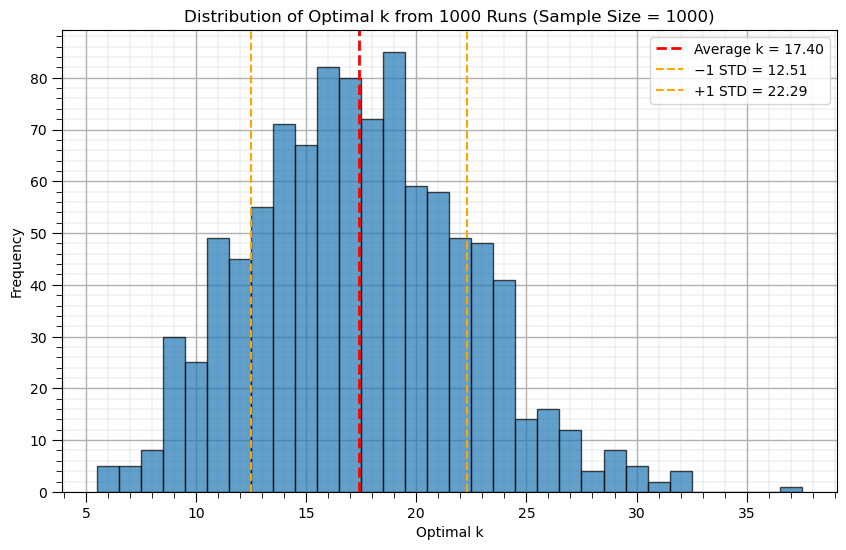

In [128]:
# --- Analyze and Plot Results ---
avg_optimal_k = np.mean(optimal_ks)
std_optimal_k = np.std(optimal_ks)
low_std = avg_optimal_k - std_optimal_k
high_std = avg_optimal_k + std_optimal_k

print(f"\nAverage Optimal k: {avg_optimal_k:.2f}")
print(f"Standard Deviation of Optimal k: {std_optimal_k:.2f}")

# Plot the distribution of optimal k values
plt.figure(figsize=(10, 6))
plt.hist(optimal_ks, bins=np.arange(min(optimal_ks)-0.5, max(optimal_ks)+1.5, 1), edgecolor='black', alpha=0.7)
plt.axvline(avg_optimal_k, color='red', linestyle='dashed', linewidth=2, label=f'Average k = {avg_optimal_k:.2f}')
plt.axvline(low_std,  color='orange', linestyle='dashed', linewidth=1.5,
            label=f'−1 STD = {low_std:.2f}')
plt.axvline(high_std, color='orange', linestyle='dashed', linewidth=1.5,
            label=f'+1 STD = {high_std:.2f}')
plt.title(f'Distribution of Optimal k from {n_iterations} Runs (Sample Size = 1000)')
plt.xlabel('Optimal k')
plt.ylabel('Frequency')
plt.legend()
add_grid()
plt.show()

## Step 3: Relationship between Optimal K and Sample Sizes: x_coor & y_coor only Model

 Given the results from the previous section, we now examine how the **distribution of optimal *K*** changes as the **sample size** varies. Specifically, we compute the distribution of optimal *K* for sample sizes of 100, 200, 300, … up to 2,700. At 2,700 samples, the data density corresponds to approximately **1 point per km²** for our study area.

This experiment is computationally expensive. For the full analysis, I ran **1,000 iterations** for each sample size to ensure statistical stability. If you want to test or reproduce the workflow without waiting hours, you can reduce the number of iterations to something like **10**, which runs much faster. However, based on the variability observed in Step 2, a high iteration count is necessary to obtain reliable estimates of the true distribution of optimal *K*.

**You can also load the results directly**

In [28]:
# --- Experiment Setup ---
sample_size = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700]
n_iterations = 1000
k_range = np.arange(1, 51)  # Test k from 1 to 50
predictor_features = ['x_coor', 'y_coor']

**Skip this section if needed, but please read the description below.**

This is the core of the experiment and involves a **three-layer looping structure**:

1. **Outer loop – Sample size:**  
   We vary the sample size from 100 to 2,700, increasing in increments of 100.

2. **Middle loop – Iterations for each sample size:**  
   For each sample size, we repeat the experiment 1000 times. Because the standard deviation of optimal *K* is relatively high (as seen in Step 2), we use a large number of iterations to obtain a stable distribution.

3. **Inner loop – Searching for the optimal *K*:**  
   Within each iteration, we tune the KNN model by testing values of *K* from 1 to 50 and recording the value that minimizes the MSE.

Together, these nested loops allow us to explore how the **distribution of optimal *K*** changes as sample size increases, giving insight into both the trend and the variability of optimal *K* across different sampling densities.


In [34]:
# Lists to store the summary statistics
avg_k_per_size = []
std_k_per_size = []
avg_mse_per_size = []

# --- Main Experiment 
# Outer loop: iterates over each sample size
for size in sample_size:
    print(datetime.datetime.now())
    print(f"Processing sample size: {size}...")
    optimal_ks_for_size = []  # Store optimal k's for the current size
    mses_for_size = []        # Store MSEs for the current size
    
    # Medium loop: repeats the CV process to find optimal k multiple times
    for i in range(n_iterations):

        # 1. Randomly sample data without replacement
        df_sample = df.sample(n=size, replace=False)
        X_sample = df_sample[predictor_features]
        y_sample = df_sample[response]

        # 2. Set up pipeline
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('knear', KNeighborsRegressor(weights='distance'))
        ])
        
        # Inner loop: hyperparameter tuning (searching for optimal K) with GridSearchCV
        # 3. Use GridSearchCV to find the best k
        params = {'knear__n_neighbors': k_range}
        grid_search = GridSearchCV(
            pipe,
            param_grid=params,
            scoring='neg_mean_squared_error',
            cv=5  # 5-fold cross-validation
        )
        
        grid_search.fit(X_sample, y_sample)
        
        # 4. Store the best k and the corresponding MSE
        optimal_ks_for_size.append(grid_search.best_params_['knear__n_neighbors'])
        mses_for_size.append(-grid_search.best_score_) # best_score_ is negative MSE
    
    # Calculate and store the mean and std of optimal k
    avg_k = np.mean(optimal_ks_for_size)
    std_k = np.std(optimal_ks_for_size)
    avg_k_per_size.append(avg_k)
    std_k_per_size.append(std_k)
    
    # Calculate and store the mean MSE
    avg_mse = np.mean(mses_for_size)
    avg_mse_per_size.append(avg_mse)
    
    print(f"  -> Avg k: {avg_k:.2f} (Std: {std_k:.2f}), Avg MSE: {avg_mse:.2f}")

print("\nExperiment complete.")



2025-11-30 16:57:49.362173
Processing sample size: 100...


KeyboardInterrupt: 

Save the results as a .csv

In [ ]:
# Create a DataFrame from the results
results_df = pd.DataFrame({
    'sample_size': sample_size,
    'avg_optimal_k': avg_k_per_size,
    'std_optimal_k': std_k_per_size,
    'avg_mse': avg_mse_per_size
})

# Save the DataFrame to a CSV file
results_df.to_csv('knn_experiment_results_x_y.csv', index=False)

# Display the results DataFrame
print("\n--- Summary of Results ---")
display(results_df)


--- Summary of Results ---


sample_size  avg_optimal_k  std_optimal_k    avg_mse
0           100         19.935      14.764037  10.621172
1           200         19.123       9.652351   9.901432
2           300         18.404       8.970105   9.482935
3           400         17.833       7.763834   9.219194
4           500         17.424       6.102313   8.983623
5           600         17.691       5.333247   8.755911
6           700         17.608       4.811895   8.599114
7           800         17.401       4.629708   8.509231
8           900         17.654       4.901865   8.381205
9          1000         17.179       4.821510   8.245411
10         1100         17.401       5.260627   8.178804
11         1200         16.733       5.049130   8.076114
12         1300         15.878       4.936306   7.981052
13         1400         15.267       4.809336   7.888480
14         1500         14.351       4.660880   7.819734
15         1600         13.799       4.628887   7.746703
16         1700         12.925       4.036505   7.678576
17         1800         12.111       3.722456   7.592296
18         1900         11.543       3.411473   7.518512
19         2000         11.035       2.999962   7.450665
20         2100         10.656       2.656250   7.377873
21         2200         10.290       2.443747   7.307594
22         2300         10.045       2.208840   7.244390
23         2400          9.656       1.993405   7.168676
24         2500          9.511       1.901021   7.112930
25         2600          9.216       1.772948   7.063366
26         2700          9.090       1.672094   6.997450

If you want to see the results, you can load the result.csv from the following: 

In [35]:
df_results = pd.read_csv("https://raw.githubusercontent.com/xyaoaf/PGE_383_TermProject_XihanYao/refs/heads/main/knn_experiment_results_x_y.csv")

The results reveal several interesting patterns:

1. **As sample size increases, the optimal *K* gradually decreases—from around 20 down to about 9.**  
   This suggests that when the sample size is small, the KNN model relies on more neighbors, which are necessarily farther apart. As a result, the predictions tend to reflect a more regional or global average. As sample size grows, however, the model can find many closer neighbors, allowing the optimal *K* to shrink. In this regime, the model relies on only a few nearby points that share more similar temperature values.

2. **The standard deviation of the optimal *K* also decreases as sample size increases.**  
   This is expected: with more data points available, the optimal *K* becomes more stable and less sensitive to which specific samples are drawn in each iteration.


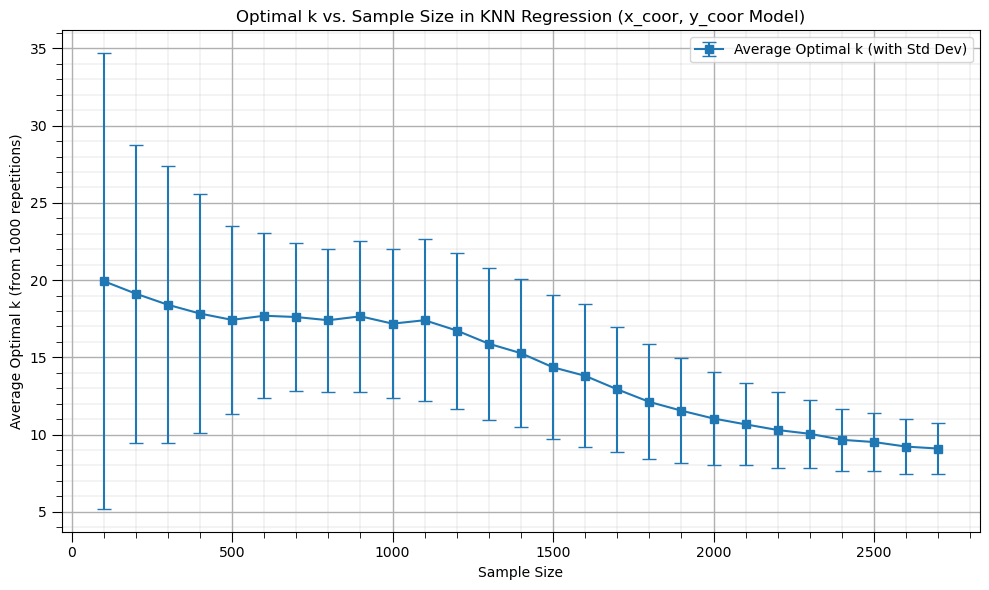

In [36]:
# --- Plot 1: Optimal k vs. Sample Size ---
plt.figure(figsize=(10, 6))
plt.errorbar(sample_size, df_results["avg_optimal_k"], yerr=df_results["std_optimal_k"], fmt='-o', capsize=5,
             marker='s', markersize=6, label='Average Optimal k (with Std Dev)')
plt.title('Optimal k vs. Sample Size in KNN Regression (x_coor, y_coor Model)')
plt.xlabel('Sample Size')
plt.ylabel(f'Average Optimal k (from {n_iterations} repetitions)')
plt.legend()
add_grid()
plt.tight_layout()
plt.show()

Without much a double, when you have more samples, the MSE is lower and the model is more accurate

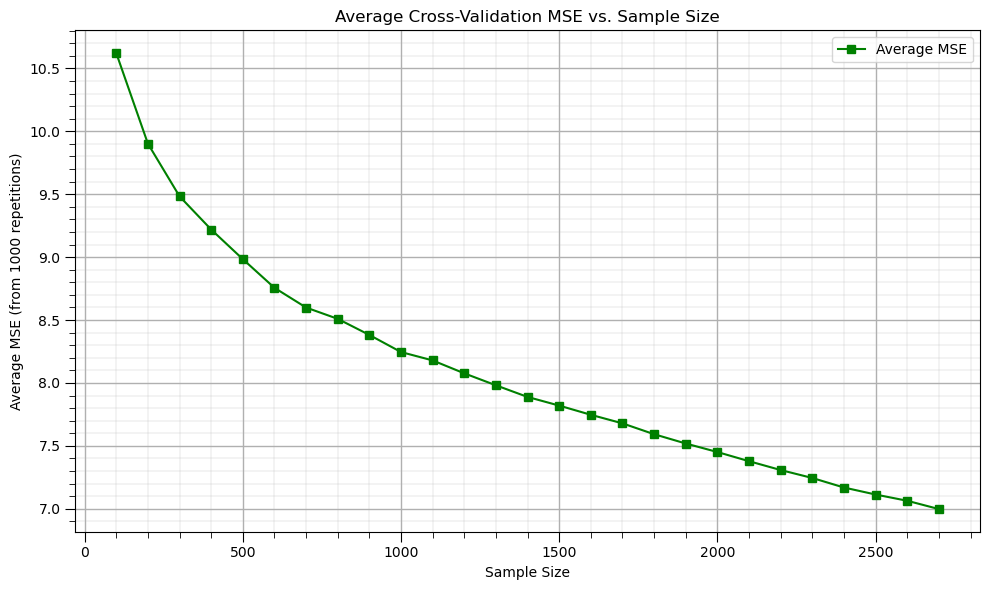

In [37]:
# --- Plot 2: MSE vs. Sample Size ---
plt.figure(figsize=(10, 6))
plt.plot(sample_size, df_results["avg_mse"], '-o', color='green', marker='s', markersize=6, label='Average MSE')
plt.title('Average Cross-Validation MSE vs. Sample Size')
plt.xlabel('Sample Size')
plt.ylabel(f'Average MSE (from {n_iterations} repetitions)')
plt.legend()
add_grid()
plt.tight_layout()
plt.show()

## Step 4: Relationship between Optimal K and Sample Sizes: x_coor, y_coor & NDVI (Normalized Vegetation Index) Model

In this final experiment, I examine whether the same patterns still hold when an additional predictive feature is included. Alongside `x_coor` and `y_coor`, I add the `NDVI` index, which measures vegetation abundance. Numerous studies have shown that NDVI is strongly related to temperature—areas with more vegetation tend to be cooler. Our exploratory analysis supports this, revealing a correlation of approximately **–0.71** between NDVI and temperature, making it one of the most informative predictors in the dataset. By combining NDVI with the spatial coordinates, we can now test whether the previously observed behavior of the optimal *K* persists under this richer feature set.

In [39]:
# --- Experiment Setup ---
n_iterations = 1000 
sample_size = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700]
k_range = np.arange(1, 51)  # Test k from 1 to 50
predictor_features = ['x_coor', 'y_coor', "NDVI"]

**!!Skip this section if needed!! This is taking a long time to run. You can load the results directly.**

This is the same loop with just one more features

In [133]:
# Lists to store the summary statistics
avg_k_per_size_ndvi = []
std_k_per_size_ndvi = []
avg_mse_per_size_ndvi = []

# --- Main Experiment 
# Outer loop: iterates over each sample size
for size in sample_size:
    print(datetime.now())
    print(f"Processing sample size: {size}...")
    optimal_ks_for_size = []  # Store optimal k's for the current size
    mses_for_size = []        # Store MSEs for the current size
    
    # Medium loop: repeats the CV process to find optimal k multiple times
    for i in range(n_iterations):

        # 1. Randomly sample data without replacement
        df_sample = df.sample(n=size, replace=False)
        X_sample = df_sample[predictor_features]
        y_sample = df_sample[response]

        # 2. Set up pipeline
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('knear', KNeighborsRegressor(weights='distance'))
        ])
        
        # Inner loop: hyperparameter tuning (searching for optimal K) with GridSearchCV
        # 3. Use GridSearchCV to find the best k
        params = {'knear__n_neighbors': k_range}
        grid_search = GridSearchCV(
            pipe,
            param_grid=params,
            scoring='neg_mean_squared_error',
            cv=5  # 5-fold cross-validation
        )
        
        grid_search.fit(X_sample, y_sample)
        
        # 4. Store the best k and the corresponding MSE
        optimal_ks_for_size.append(grid_search.best_params_['knear__n_neighbors'])
        mses_for_size.append(-grid_search.best_score_) # best_score_ is negative MSE
    
    # Calculate and store the mean and std of optimal k
    avg_k = np.mean(optimal_ks_for_size)
    std_k = np.std(optimal_ks_for_size)
    avg_k_per_size_ndvi.append(avg_k)
    std_k_per_size_ndvi.append(std_k)
    
    # Calculate and store the mean MSE
    avg_mse = np.mean(mses_for_size)
    avg_mse_per_size_ndvi.append(avg_mse)
    
    print(f"  -> Avg k: {avg_k:.2f} (Std: {std_k:.2f}), Avg MSE: {avg_mse:.2f}")

print("\nExperiment complete.")



2025-11-28 05:11:36.984411
Processing sample size: 100...
  -> Avg k: 9.17 (Std: 4.18), Avg MSE: 6.34
2025-11-28 05:21:04.577053
Processing sample size: 200...
  -> Avg k: 11.79 (Std: 4.45), Avg MSE: 5.79
2025-11-28 05:29:03.499969
Processing sample size: 300...
  -> Avg k: 13.10 (Std: 4.55), Avg MSE: 5.55
2025-11-28 05:37:45.580990
Processing sample size: 400...
  -> Avg k: 14.52 (Std: 4.66), Avg MSE: 5.46
2025-11-28 05:47:00.974288
Processing sample size: 500...
  -> Avg k: 15.30 (Std: 4.74), Avg MSE: 5.33
2025-11-28 05:56:50.459324
Processing sample size: 600...
  -> Avg k: 16.42 (Std: 4.85), Avg MSE: 5.23
2025-11-28 06:07:44.074580
Processing sample size: 700...
  -> Avg k: 17.40 (Std: 4.77), Avg MSE: 5.17
2025-11-28 06:19:18.572362
Processing sample size: 800...
  -> Avg k: 17.99 (Std: 4.95), Avg MSE: 5.12
2025-11-28 06:31:25.460608
Processing sample size: 900...
  -> Avg k: 18.33 (Std: 5.02), Avg MSE: 5.06
2025-11-28 06:43:19.084215
Processing sample size: 1000...
  -> Avg k: 18.

Save the results

In [134]:
# --- Save and Display Results ---
# Create a DataFrame from the results
results_df_ndvi = pd.DataFrame({
    'sample_size': sample_size,
    'avg_optimal_k': avg_k_per_size_ndvi,
    'std_optimal_k': std_k_per_size_ndvi,
    'avg_mse': avg_mse_per_size_ndvi
})

# Save the DataFrame to a CSV file
results_df_ndvi.to_csv('knn_experiment_results_x_y_ndvi.csv', index=False)

# Display the results DataFrame
print("\n--- Summary of Results ---")
display(results_df_ndvi)


--- Summary of Results ---


sample_size  avg_optimal_k  std_optimal_k   avg_mse
0           100          9.169       4.183114  6.338245
1           200         11.792       4.446654  5.785653
2           300         13.095       4.547304  5.554618
3           400         14.516       4.655507  5.458682
4           500         15.296       4.742403  5.328487
5           600         16.424       4.851415  5.229828
6           700         17.403       4.773949  5.171169
7           800         17.989       4.945390  5.117411
8           900         18.330       5.020468  5.062992
9          1000         18.805       5.206628  5.027923
10         1100         19.310       5.342088  4.987774
11         1200         19.506       5.409433  4.960828
12         1300         19.553       5.544113  4.939494
13         1400         19.786       5.316221  4.903675
14         1500         19.570       4.944199  4.897027
15         1600         19.999       4.881291  4.857655
16         1700         19.990       4.847670  4.841960
17         1800         20.294       4.637409  4.830883
18         1900         20.147       4.395155  4.803853
19         2000         20.741       4.139314  4.792639
20         2100         20.744       3.915924  4.776643
21         2200         21.133       3.900681  4.756905
22         2300         21.241       3.724905  4.744438
23         2400         21.626       3.630444  4.732496
24         2500         21.752       3.693033  4.713598
25         2600         22.174       3.378124  4.701784
26         2700         22.674       3.622668  4.699186

If you want to see the results, you can load the result.csv from the following: 

In [135]:
df_results2 = pd.read_csv("https://raw.githubusercontent.com/xyaoaf/PGE_383_TermProject_XihanYao/refs/heads/main/knn_experiment_results_x_y_ndvi.csv")

**HOW INTERESTING!**

In this case, the results show the **opposite pattern** compared to the first model, where only the x- and y-coordinates were used. After adding NDVI as a third predictor, the relationship between sample size and optimal *K* changes dramatically. 

1. **As sample size increases, the optimal *K* gradually increases—from about 9 up to roughly 23.**  
   This indicates that as the sample size grows, the model shifts toward using a broader neighborhood. With more data available—especially with NDVI included as a strong linear predictor—the model benefits from averaging across a larger set of neighbors, leading to a steadily increasing optimal *K*.

2. **The standard deviation of the optimal *K* remains relatively constant across sample sizes.**  
   Unlike the coordinate-only model, the inclusion of NDVI results in a consistently stable level of variability.


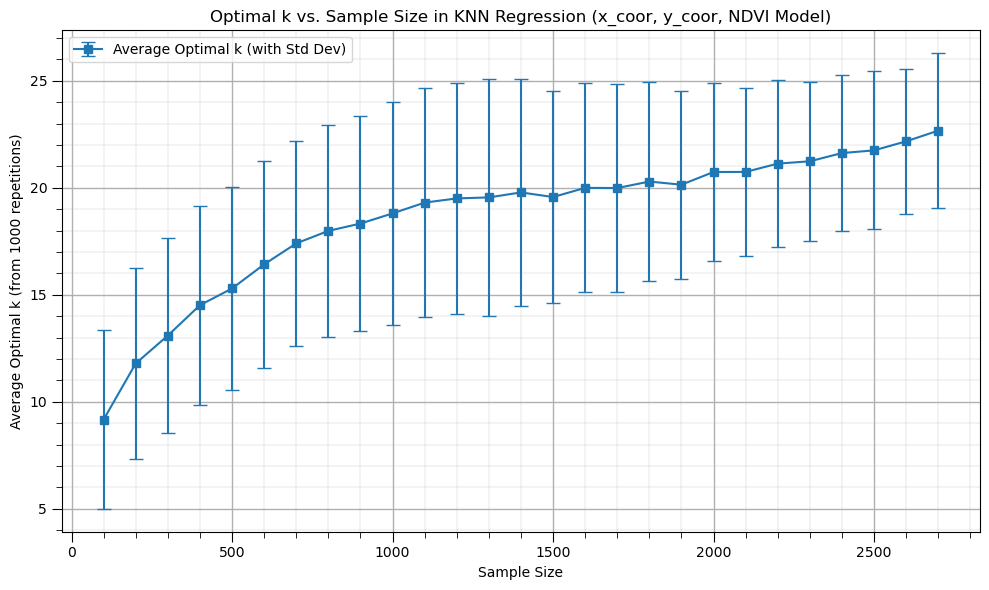

In [140]:
# --- Plot 1: Optimal k vs. Sample Size ---
plt.figure(figsize=(10, 6))
plt.errorbar(sample_size, df_results2["avg_optimal_k"], yerr=df_results2["std_optimal_k"], fmt='-o', capsize=5,
             marker='s', markersize=6, label='Average Optimal k (with Std Dev)')
plt.title('Optimal k vs. Sample Size in KNN Regression (x_coor, y_coor, NDVI Model)')
plt.xlabel('Sample Size')
plt.ylabel(f'Average Optimal k (from {n_iterations} repetitions)')
plt.legend()
add_grid()
plt.tight_layout()
plt.show()

Without a suprise, the 3-feature model out-perform teh 2-feature model. MSE steadly decrease as sample size increase and the model is more reliable

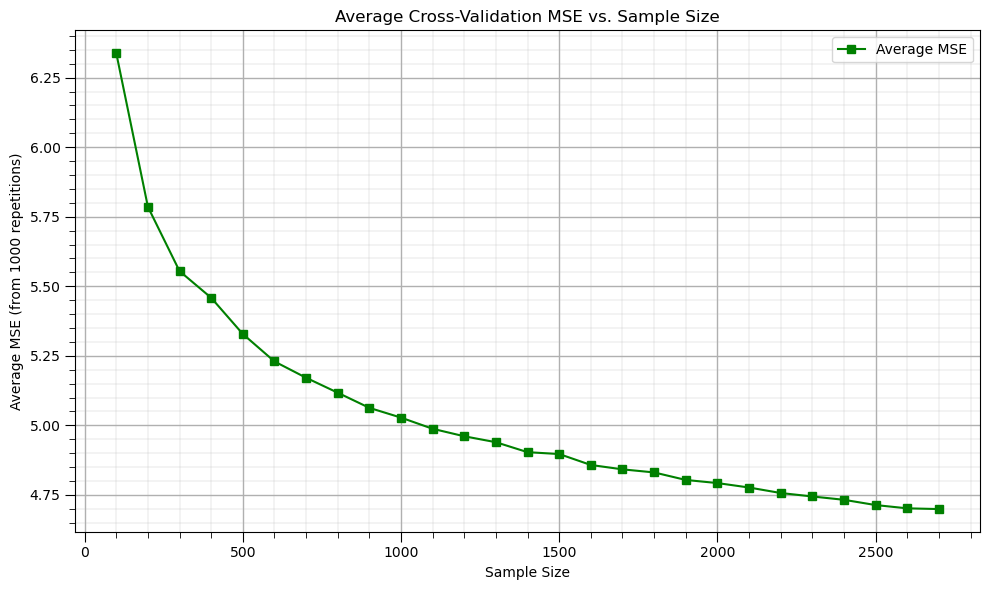

In [139]:
# --- Plot 2: MSE vs. Sample Size ---
plt.figure(figsize=(10, 6))
plt.plot(sample_size, df_results2["avg_mse"], '-o', color='green', marker='s', markersize=6, label='Average MSE')
plt.title('Average Cross-Validation MSE vs. Sample Size')
plt.xlabel('Sample Size')
plt.ylabel(f'Average MSE (from {n_iterations} repetitions)')
plt.legend()
add_grid()
plt.tight_layout()
plt.show()

## Results and Discussion

Across Step 3 and 4, we observe two distinct patterns in how the optimal K of a KNN model changes with sample size, and these differences highlight the strong influence of feature selection on neighborhood structure in geospatial modeling.

In the coordinate-only model (Step 3), the optimal K **decreases** as sample size increases, from around 20 with small samples to about 9 with larger samples. This behavior aligns with spatial intuition: when only geographic coordinates are available, the model must rely on broader neighborhoods at low sampling densities and generate a more regional or global average value. As sampling density increases, more local neighbors become available, enabling the model to make predictions using only a few, highly relevant nearby points. Correspondingly, the standard deviation of optimal K also decreases with sample size, indicating that the model’s neighborhood preference becomes more stable as more spatial samples are introduced.

In contrast, when NDVI is incorporated as an additional predictor (Step 4), the relationship reverses. The optimal K **increases** with sample size, from roughly 9 at low densities to around 23 when sample size reaches 2,700. The standard deviation of optimal K remains relatively constant, suggesting a stable preference for broader neighborhoods. This reversal is driven by the strong linear relationship between NDVI and temperature (correlation ≈ –0.71). With NDVI included, KNN benefits from averaging over a larger set of neighbors because each additional point provides meaningful information.

Together, these results demonstrate that optimal neighborhood size is not solely a function of sampling density—it is deeply shaped by the geometry and informativeness of the feature space. When predictive features exhibit nonlinear spatial relationships (as with x and y), KNN tends to localize its predictions at higher sample densities. But when strong linear predictors like NDVI are introduced, the opposite is observed. This provides valuable insight for geospatial machine learning: selecting appropriate features can fundamentally change the behavior and tuning requirements of KNN models, especially in studies where sampling density varies or is constrained by field collection costs.

#### About the Author

**Xihan Yao** is a PhD student in the Department of Geography and the Environment at the University of Texas at Austin. He completed his Master’s degree in Environmental Planning at UC Berkeley. His work specializes in GIS, remote sensing, GeoAI, and their applications in environmental modeling and human–environment interactions.  

For more information, please visit his LinkedIn profile:  
https://www.linkedin.com/in/xihan-yao-6381b3181/


#### About the Supervising Professor

Michael Pyrcz is a professor in the [Cockrell School of Engineering](https://cockrell.utexas.edu/faculty-directory/alphabetical/p), and the [Jackson School of Geosciences](https://www.jsg.utexas.edu/researcher/michael_pyrcz/), at [The University of Texas at Austin](https://www.utexas.edu/), where he researches and teaches subsurface, spatial data analytics, geostatistics, and machine learning. Michael is also,

* the principal investigator of the [Energy Analytics](https://fri.cns.utexas.edu/energy-analytics) freshmen research initiative and a core faculty in the Machine Learn Laboratory in the College of Natural Sciences, The University of Texas at Austin

* an associate editor for [Computers and Geosciences](https://www.sciencedirect.com/journal/computers-and-geosciences/about/editorial-board), and a board member for [Mathematical Geosciences](https://link.springer.com/journal/11004/editorial-board), the International Association for Mathematical Geosciences. 

Michael has written over 70 [peer-reviewed publications](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en), a [Python package](https://pypi.org/project/geostatspy/) for spatial data analytics, co-authored a textbook on spatial data analytics, [Geostatistical Reservoir Modeling](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) and author of two recently released e-books, [Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) and [Applied Machine Learning in Python: a Hands-on Guide with Code](https://geostatsguy.github.io/MachineLearningDemos_Book/intro.html).

All of Michael’s university lectures are available on his [YouTube Channel](https://www.youtube.com/@GeostatsGuyLectures) with links to 100s of Python interactive dashboards and well-documented workflows in over 40 repositories on his [GitHub account](https://github.com/GeostatsGuy), to support any interested students and working professionals with evergreen content. To find out more about Michael’s work and shared educational resources visit his [Website](www.michaelpyrcz.com).

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PI is Professor John Foster)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)